In [1]:
import numpy as np
import pandas as pd
import glob
import tabulate
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from diffusion.lightning_modules import MNISTDataModule
from diffusion.vgg5 import VGG5
import tqdm
from sklearn.metrics import confusion_matrix
import math

import os

c:\Users\niels\anaconda3\envs\bachelor\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plot_path = './plots/'

work_dir = r'C:\Users\niels\local_data\bachelor'

models_dir = os.path.join(work_dir, 'models')
read_train_logs = lambda dir: pd.read_csv(os.path.join(dir, 'metrics.csv'))

In [3]:
data_dir = os.path.join(work_dir, 'datasets')
datamodule = MNISTDataModule(data_dir, 64)
datamodule.prepare_data()
datamodule.setup('fit')
val_dataloader = datamodule.val_dataloader()

# classifier

In [4]:
classifier_dir = os.path.join(models_dir, r'vgg5_mnist-42\lightning_logs\version_0')
classifier_logs = read_train_logs(classifier_dir)
classifier_logs.head()

,train_acc,train_loss,epoch,step,valid_acc,val_loss
0,0.335938,1.822013,0,9,NaN,NaN
1,0.671875,1.037147,0,19,NaN,NaN
2,0.812500,0.633017,0,29,NaN,NaN
3,0.882812,0.373009,0,39,NaN,NaN
4,0.929688,0.258966,0,49,NaN,NaN


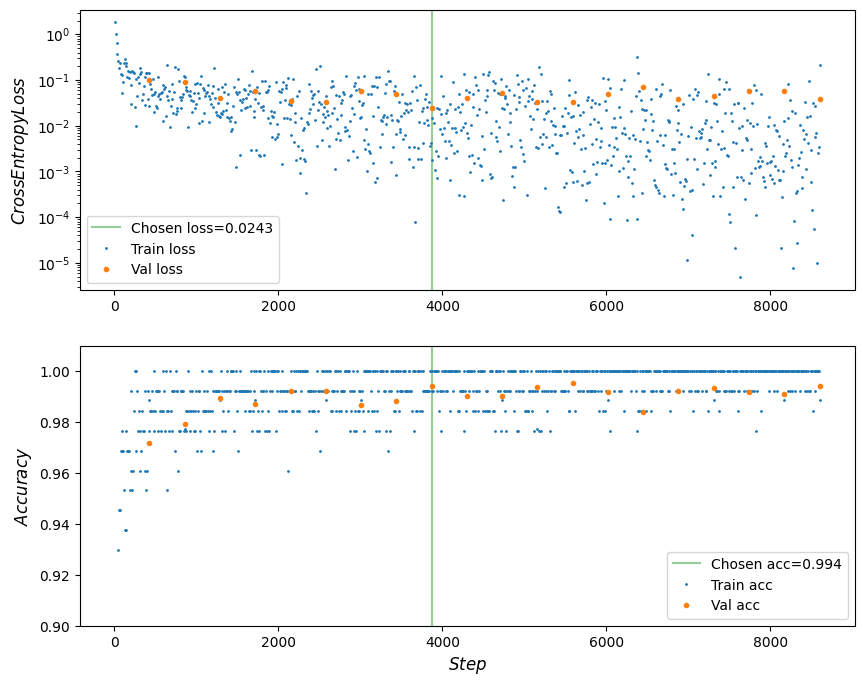

In [5]:
classifier_train_logs = classifier_logs.set_index('step')[['train_acc', 'train_loss']].dropna()
classifier_val_logs = classifier_logs.set_index('step')[['valid_acc', 'val_loss']].dropna()
best_index = classifier_val_logs['val_loss'].argmin()
chosen_step = classifier_val_logs.index[best_index]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 8))
text_size = 12

ax1.axvline(chosen_step, color='C2', label=f"Chosen loss={classifier_val_logs['val_loss'][chosen_step]:.3}", alpha=0.5)
ax1.plot(classifier_train_logs['train_loss'], '.', markersize=2, label='Train loss')
ax1.plot(classifier_val_logs['val_loss'], '.', label='Val loss')
ax1.set_yscale('log')
ax1.set_ylabel('$CrossEntropyLoss$', size=text_size)
ax1.legend()

ax2.axvline(chosen_step, color='C2', label=f"Chosen acc={classifier_val_logs['valid_acc'][chosen_step]:.3}", alpha=0.5)
ax2.plot(classifier_train_logs['train_acc'], '.', markersize=2, label='Train acc')
ax2.plot(classifier_val_logs['valid_acc'], '.', label='Val acc')
ax2.set_ylim(0.9, 1.01)
ax2.set_xlabel('$Step$', size=text_size)
ax2.set_ylabel('$Accuracy$', size=text_size)
ax2.legend()

plt.savefig(plot_path + 'classifier_train')

_ = plt.show()

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
classifier = VGG5.load_from_checkpoint(os.path.join(work_dir, 'eval_models', 'classifier.ckpt')).to(device).eval()

In [7]:
torch.cuda.empty_cache()
all_y = list()
all_preds = list()

wrongs = list()

for x, y in tqdm.tqdm(val_dataloader):
    preds = classifier(x.to(device))
    all_y.append(y)
    all_preds.append(preds)
    for ii, (y_, pred_) in enumerate(zip(y, preds)):
        pred_ = pred_.argmax()
        if y_ != pred_:
            wrongs.append((x[ii].detach().cpu().numpy(), int(y_), int(pred_)))

all_y = torch.cat(all_y).detach().cpu().numpy()
all_outs = torch.cat(all_preds).detach().cpu().numpy()
all_preds = all_outs.argmax(1)
torch.cuda.empty_cache()

100%|██████████| 79/79 [00:38<00:00,  2.05it/s]


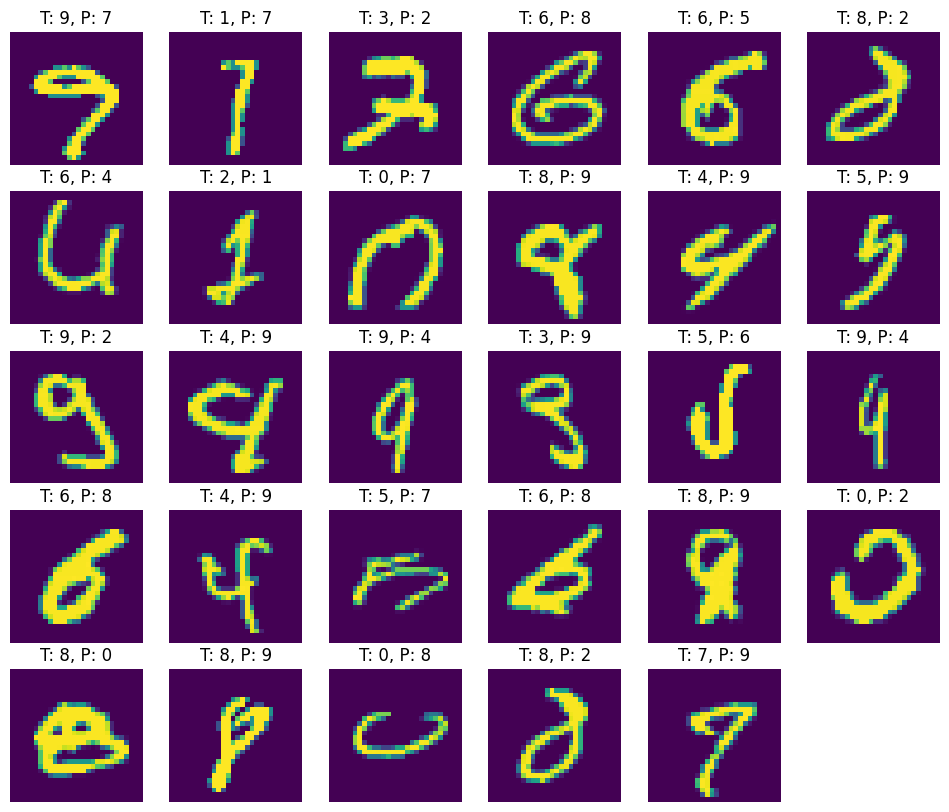

In [8]:
from diffusion.data_util import show_out_images
img, true, pred = zip(*wrongs)

title = [f'T: {t}, P: {p}' for t, p in zip(true, pred)]
show_out_images(np.array(img), title, fig_shape=(6,5), )
plt.savefig(plot_path + 'classifier_wrong_val_predictions', bbox_inches='tight')

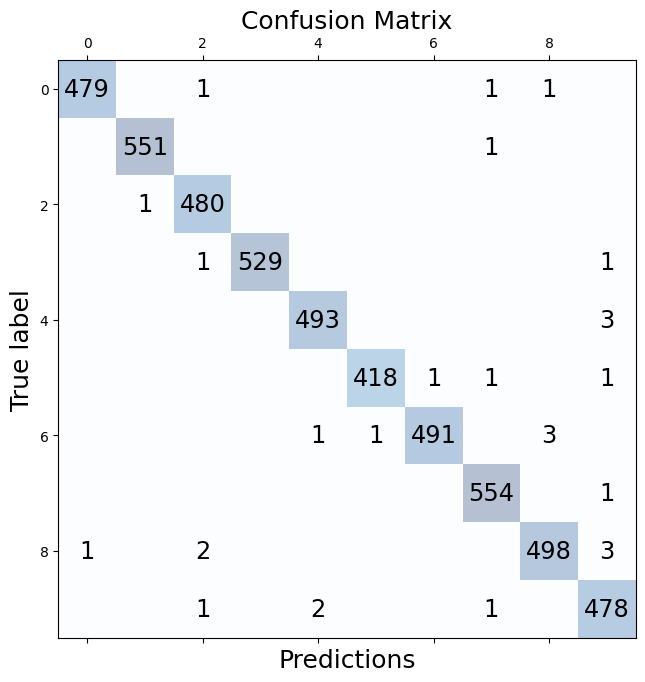

In [9]:
conf_matrix = confusion_matrix(all_y, all_preds)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        text = conf_matrix[i, j]
        text = text if text else ' '
        ax.text(x=j, y=i, s=text, va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('True label', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)

plt.savefig(plot_path + 'classifier_val_conf_matrix')

# VAE

In [10]:
vae_dir = os.path.join(models_dir, r'vae_mnist-42\lightning_logs\version_0')
vae_logs = read_train_logs(vae_dir)
vae_logs.head()

,train_loss,epoch,step,val_loss
0,537.185364,0,9,NaN
1,523.800720,0,19,NaN
2,486.207214,0,29,NaN
3,398.543762,0,39,NaN
4,300.274506,0,49,NaN


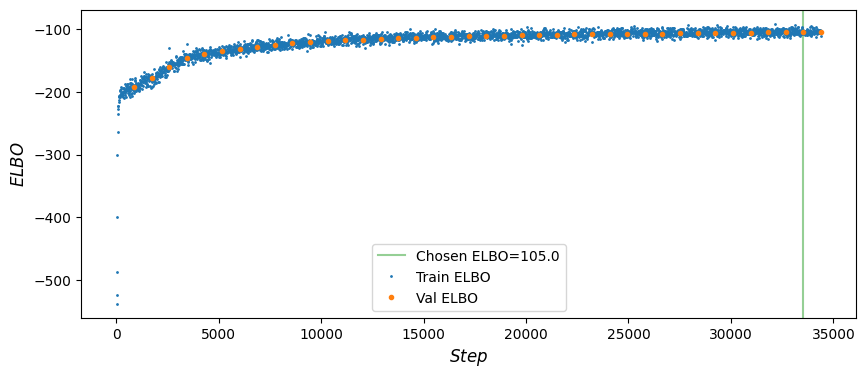

In [11]:
vae_train_logs = vae_logs.set_index('step')['train_loss'].dropna()
vae_val_logs = vae_logs.set_index('step')['val_loss'].dropna()
best_index = vae_val_logs.argmin()
chosen_step = vae_val_logs.index[best_index]

fig, ax = plt.subplots(figsize=(10, 4))
text_size = 12

ax.axvline(chosen_step, color='C2', label=f"Chosen ELBO={vae_val_logs[chosen_step]:.4}", alpha=0.5)
ax.plot(-vae_train_logs, '.', markersize=2, label='Train ELBO')
ax.plot(-vae_val_logs, '.', label='Val ELBO')
ax.set_xlabel('$Step$', size=text_size)
ax.set_ylabel('$ELBO$', size=text_size)
ax.legend()

plt.savefig(plot_path + 'vae_train')

_ = plt.show()

In [17]:
from diffusion.vae import SimpleVAE
vae = SimpleVAE.load_from_checkpoint(os.path.join(work_dir, 'eval_models', 'vae.ckpt')).to(device).eval()

In [41]:
val_iter = iter(val_dataloader)
_ = [next(val_iter) for _ in range(4)]

batch = next(val_iter)
x, y = batch


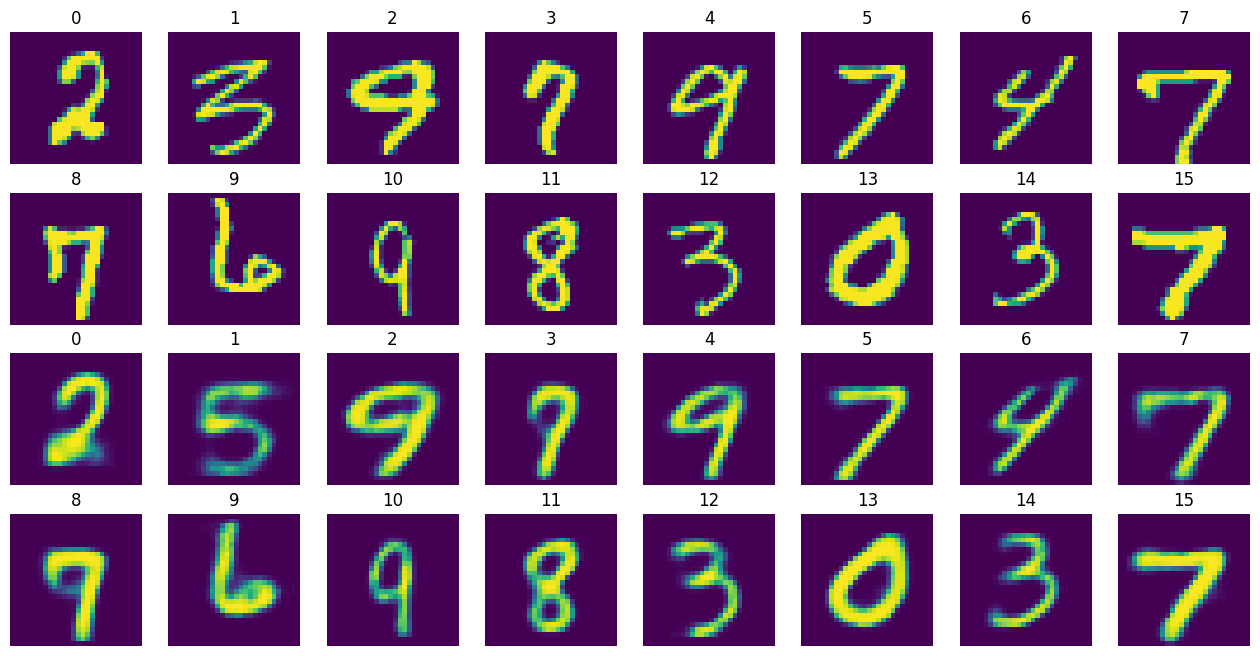

In [42]:
reconstructs = torch.sigmoid(vae(x[:16].to(device)))

imgs = torch.cat((x[:16].to(device), reconstructs))
titles = torch.cat((torch.arange(16), torch.arange(16)))
show_out_images(imgs, titles, fig_shape=(8,4))

plt.savefig(plot_path + 'vae_reconstructions', bbox_inches='tight')

# DDPM cond

In [65]:
def plot_train_val_loss(logs: pd.DataFrame, show_advanced=True, figsize=(10, 4), chosen_alpha=0.5, train_marker_alpha=0.3):
    if ('train_vlb_loss' in logs.columns) and show_advanced:
        train_logs = logs.set_index('step')[['train_loss', 'train_vlb_loss']].dropna()
        val_logs = logs.set_index('step')[['val_loss', 'val_vlb_loss']].dropna()
        best_index = val_logs['val_loss'].argmin()
        chosen_step = val_logs.index[best_index]

        train_logs['train_simple_loss'] = train_logs['train_loss'] - train_logs['train_vlb_loss']
        val_logs['val_simple_loss'] = val_logs['val_loss'] - val_logs['val_vlb_loss']

        fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(figsize[0], 3*figsize[1]))
        text_size = 12

        ax1.axvline(chosen_step, color='C2', label=f"Chosen $L$={val_logs['val_loss'][chosen_step]:.3}", alpha=chosen_alpha)
        ax1.plot(train_logs['train_loss'], '.', markersize=1, label='Train loss', alpha=train_marker_alpha)
        ax1.plot(val_logs['val_loss'], '.', label='Val loss')
        ax1.set_yscale('log')
        ax1.set_ylabel('$Loss$', size=text_size)
        ax1.legend()

        ax2.axvline(chosen_step, color='C2', label="Chosen $L_{simple}$=" + f"{val_logs['val_simple_loss'][chosen_step]:.3}", alpha=chosen_alpha)
        ax2.plot(train_logs['train_simple_loss'], '.', markersize=1, label='Train loss', alpha=train_marker_alpha)
        ax2.plot(val_logs['val_simple_loss'], '.', label='Val loss')
        ax2.set_yscale('log')
        ax2.set_ylabel('$Loss_{simple}$', size=text_size)
        ax2.legend()

        ax3.axvline(chosen_step, color='C2', label="Chosen $L_{vlb}$=" + f"{val_logs['val_vlb_loss'][chosen_step]:.3}", alpha=chosen_alpha)
        ax3.plot(train_logs['train_vlb_loss'], '.', markersize=1, label='Train loss', alpha=train_marker_alpha)
        ax3.plot(val_logs['val_vlb_loss'], '.', label='Val loss')
        ax3.set_yscale('log')
        ax3.set_xlabel('$Step$', size=text_size)
        ax3.set_ylabel('$Loss_{vlb}$', size=text_size)
        ax3.legend()
        
    elif not show_advanced:
        train_logs = logs.set_index('step')['train_loss'].dropna()
        val_logs = logs.set_index('step')['val_loss'].dropna()
        best_index = val_logs.argmin()
        chosen_step = val_logs.index[best_index]

        fig, (ax, ax2) = plt.subplots(nrows=2, figsize=(figsize[0], 2*figsize[1]))
        text_size = 12

        loss_label = '$Loss_{simple}$' if 'train_vlb_loss' not in logs.columns else '$Loss$'
        ax.axvline(chosen_step, color='C2', label="Chosen "+loss_label+"=" + f"{val_logs[chosen_step]:.3}", alpha=chosen_alpha)
        ax.plot(train_logs, '.', markersize=1, label='Train loss', alpha=train_marker_alpha)
        ax.plot(val_logs, '.', label='Val loss')
        ax.set_yscale('log')
        ax.set_ylabel(loss_label, size=text_size)
        ax.legend()
        
        eval_columns = [c for c in logs.columns if ('acc' in c) or ('FVAED' in c)]
        eval_logs = logs.set_index('step')[eval_columns].dropna(how='all')
        
        best_index = eval_logs['FVAED'].argmin()
        chosen_step = eval_logs.index[best_index]
        # ax2.axvline(chosen_step, color='C2', label="Chosen "+loss_label+"=" + f"{eval_logs['FVAED'][chosen_step]:.3}", alpha=chosen_alpha)
        ax2.plot(eval_logs['FVAED'], '-', label='ALL')
        ax2.set_xlabel('$Step$', size=text_size)
        ax2.set_ylabel('$FVEAD$', size=text_size)
        ax2.legend()
    
    else:
        train_logs = logs.set_index('step')['train_loss'].dropna()
        val_logs = logs.set_index('step')['val_loss'].dropna()
        best_index = val_logs.argmin()
        chosen_step = val_logs.index[best_index]

        fig, ax = plt.subplots(figsize=figsize)
        text_size = 12

        ax.axvline(chosen_step, color='C2', label="Chosen $L_{simple}$=" + f"{val_logs[chosen_step]:.3}", alpha=chosen_alpha)
        ax.plot(train_logs, '.', markersize=1, label='Train loss', alpha=train_marker_alpha)
        ax.plot(val_logs, '.', label='Val loss')
        ax.set_yscale('log')
        ax.set_xlabel('$Step$', size=text_size)
        ax.set_ylabel('$Loss_{simple}$', size=text_size)
        ax.legend()
        
    return fig

def plot_eval_performance(logs: pd.DataFrame, smoothing=10, top_k_accs=3, figsize=(10, 4), chosen_alpha=0.5, text_size=16, num_labels=10):
    val_logs = logs.set_index('step')['val_loss'].dropna()
    best_index = val_logs.argmin()
    chosen_step = val_logs.index[best_index]
    
    eval_columns = [c for c in logs.columns if ('acc' in c) or ('FVAED' in c)]
    eval_logs = logs.set_index('step')[eval_columns].dropna(how='all')
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(figsize[0], 3*figsize[1]))

    ax1.axvline(chosen_step, color='C2', label=f"Chosen", alpha=chosen_alpha)
    ax2.axvline(chosen_step, color='C2', label=f"Chosen", alpha=chosen_alpha)
    ax3.axvline(chosen_step, color='C2', label=f"Chosen", alpha=chosen_alpha)

    for k in range(1, top_k_accs+1):
        ax1.plot(eval_logs[f'top_{k}_acc'], '-', label=f'Top {k}')
    ax1.set_ylabel('$Accuracy$', size=text_size)
    ax1.legend()

    ax2.plot(eval_logs['FVAED'], '-', label='ALL')
    ax2.set_ylabel('$FVEAD$', size=text_size)
    ax2.legend()

    # colors = ["#0000ff", "#1984c5", "#22a7f0", "#63bff0", "#a7d5ed", "#e2e2e2", "#e1a692", "#de6e56", "#e14b31", "#c23728"]
    
    for label in range(num_labels):
        values = eval_logs[f'FVAED_{label}']
        xs = values.index
        
        # do running average on values
        values = np.pad(values, (math.ceil(smoothing/2) - 1, math.floor(smoothing/2)), mode='edge')
        values = np.convolve(values, np.ones(smoothing)/smoothing, mode='valid')
        
        ax3.plot(xs, values, '-', label=label)#, color=colors[label])
        ax3.set_xlabel('$step$', size=text_size)
        ax3.set_ylabel('$FVEAD$', size=text_size)
        # ax3.set_yscale('log')
        ax3.legend()

    return fig

## predicted var

In [9]:
weight = '0_001'

cond_pred_dir = os.path.join(models_dir, fr'cond-learned-var-lw={weight}-42\lightning_logs\version_0')
cond_pred_logs = read_train_logs(cond_pred_dir)
cond_pred_logs.columns

Index(['train_vlb_loss', 'train_loss', 'epoch', 'step', 'val_vlb_loss',
       'val_loss', 'top_1_acc', 'top_2_acc', 'top_3_acc', 'top_4_acc',
       'top_5_acc', 'top_6_acc', 'top_7_acc', 'top_8_acc', 'top_9_acc',
       'FVAED', 'FVAED_0', 'FVAED_1', 'FVAED_2', 'FVAED_3', 'FVAED_4',
       'FVAED_5', 'FVAED_6', 'FVAED_7', 'FVAED_8', 'FVAED_9'],
      dtype='object')

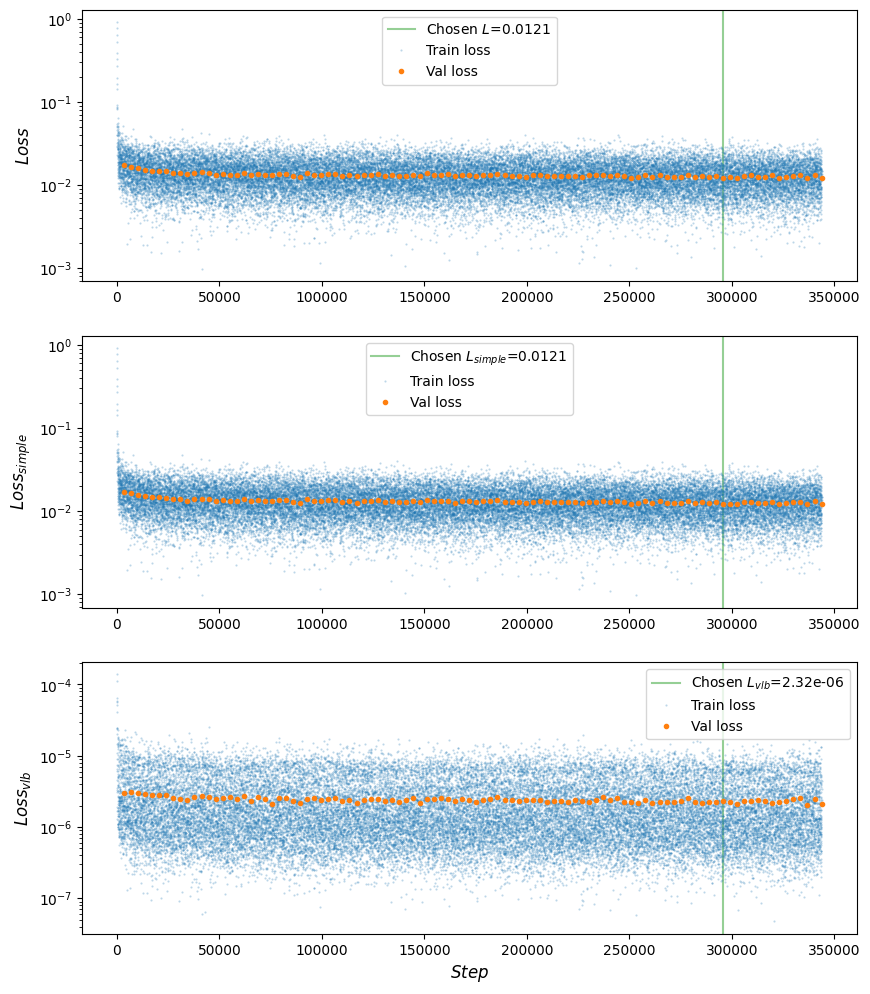

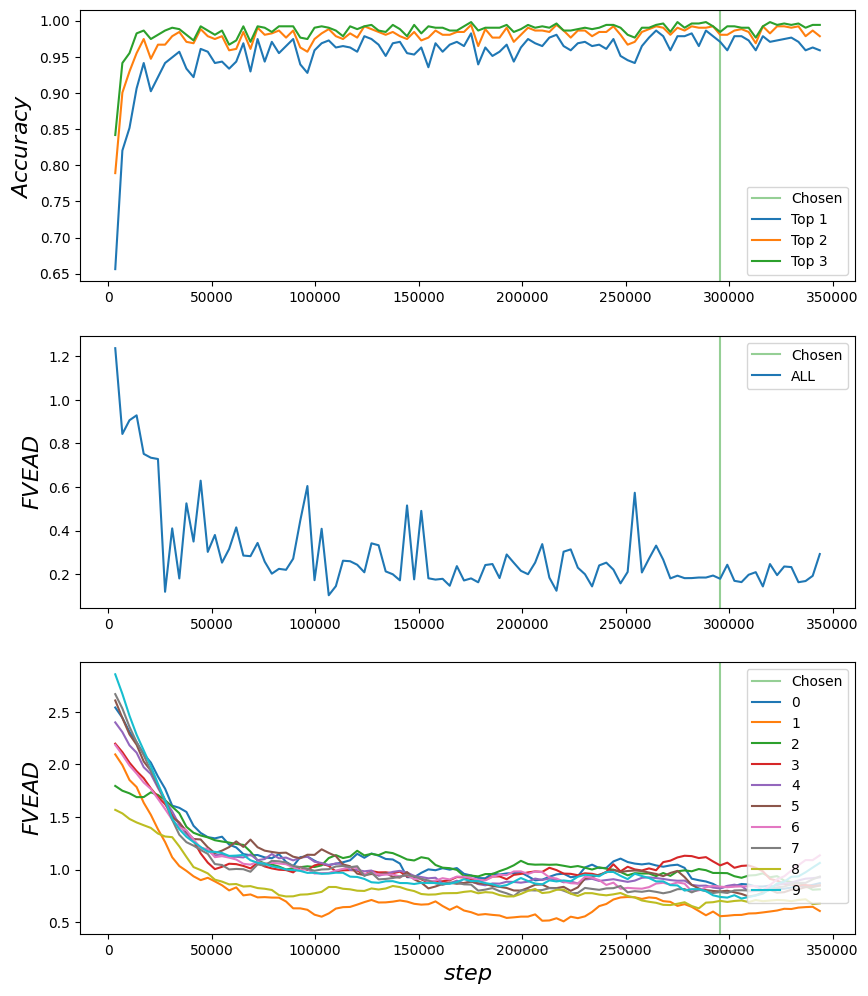

In [45]:
plot_train_val_loss(cond_pred_logs)
plt.savefig(plot_path + 'cond_ddpm_loss_curve', bbox_inches='tight')
plt.show()

fig = plot_eval_performance(cond_pred_logs, smoothing=15)
plt.savefig(plot_path + 'cond_ddpm_eval_performance', bbox_inches='tight')
plt.show()

# Compare trainings

In [15]:
top_k_acc = 3

max_step = -1 # 250973

paths = glob.glob(models_dir + '/cond*/**/*.csv', recursive=True)
model_name = ['Predicted w=' + p.split('=')[1].split('-')[0].replace('_', '.') if '=' in p else 'Scheduled' for p in paths]


headers = ['Model', 'Step', 'Val loss', 'FVAED', 'Avg. FVAED'] + [f'Top {i} acc' for i in range(1, top_k_acc+1)]
table = list()
for n, p in zip(model_name, paths):
    log = pd.read_csv(p).set_index('step')
    if max_step >= 0:
        log = log[log.index <= max_step]
    min_val_loss = log['val_loss'].min()
    min_val_loss_idx = log['val_loss'].argmin()
    min_val_loss_step = log.index[int(min_val_loss_idx)]
    
    chosen_acc = list()
    for i in range(1, top_k_acc+1):
        chosen_acc.append(log[f'top_{i}_acc'].dropna()[min_val_loss_step])
    
    log_fvaed = log['FVAED'].dropna()
    
    chosen_idx = log['val_loss'].dropna().argmin()
    end_range = min(chosen_idx+5, len(log_fvaed))
    min_val_loss_step_range = log_fvaed.index[np.arange(end_range-9, end_range, step=1, dtype=int)]
    
    chosen_fvaed = log_fvaed[min_val_loss_step]
    chosen_fvaed_avg = log_fvaed[min_val_loss_step_range].mean()
    
    table.append([n, int(min_val_loss_step), min_val_loss, chosen_fvaed, chosen_fvaed_avg, *chosen_acc])

print(tabulate.tabulate(table, headers=headers, floatfmt='.3f', intfmt='g', tablefmt='simple'))

if True:
    idxs = [i for i, t in enumerate(headers) if 'acc' not in t]
    tmp_table = [[row[i] for i in idxs] for row in table]
    tmp_headers = [headers[i] for i in idxs]
    print(tabulate.tabulate(tmp_table, headers=tmp_headers, floatfmt='.3f', intfmt='g', tablefmt='latex'))
    
    
    idxs = [i for i, t in enumerate(headers) if 'acc' in t or t == 'Model']
    tmp_table = [[row[i] for i in idxs] for row in table]
    tmp_headers = [headers[i] for i in idxs]
    print(tabulate.tabulate(tmp_table, headers=tmp_headers, floatfmt='.3f', intfmt='g', tablefmt='latex'))

Model                Step    Val loss    FVAED    Avg. FVAED    Top 1 acc    Top 2 acc    Top 3 acc
-----------------  ------  ----------  -------  ------------  -----------  -----------  -----------
Predicted w=0.001  295667       0.012    0.178         0.188        0.971        0.980        0.984
Predicted w=0.01   295667       0.012    0.216         0.182        0.973        0.986        0.988
Predicted w=0.1    295667       0.012    0.208         0.189        0.975        0.986        0.988
Predicted w=1.0    250973       0.014    0.193         0.254        0.957        0.979        0.988
Scheduled          250973       0.012    0.234         0.259        0.955        0.975        0.982
\begin{tabular}{lrrrr}
\hline
 Model             &   Step &   Val loss &   FVAED &   Avg. FVAED \\
\hline
 Predicted w=0.001 & 295667 &      0.012 &   0.178 &        0.188 \\
 Predicted w=0.01  & 295667 &      0.012 &   0.216 &        0.182 \\
 Predicted w=0.1   & 295667 &      0.012 &   0.208 &    

# uncond

In [49]:
uncond_pred_dir = os.path.join(models_dir, fr'uncond-learned-42\lightning_logs\version_0')
uncond_pred_logs = read_train_logs(uncond_pred_dir)
uncond_pred_logs.columns

Index(['train_vlb_loss', 'train_loss', 'epoch', 'step', 'val_vlb_loss',
       'val_loss', 'FVAED'],
      dtype='object')

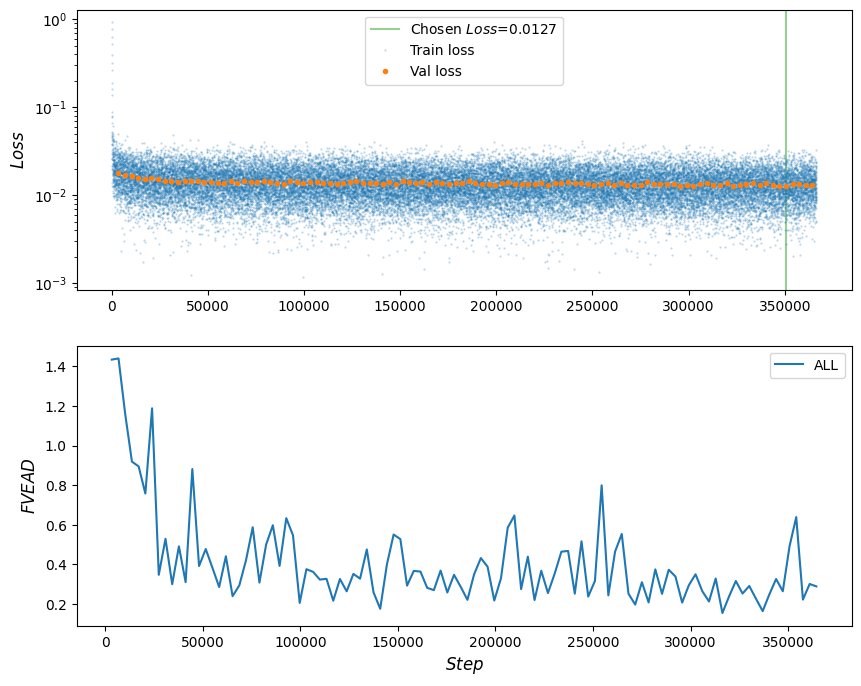

In [67]:
plot_train_val_loss(uncond_pred_logs, show_advanced=False)
plt.savefig(plot_path + 'uncond_ddpm_loss_curve', bbox_inches='tight')
plt.show()